In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def f(x):
    return 4*x**2 - 7*x + 5

In [ ]:
f(2.0)

In [ ]:
xs = np.arange(-5, 5, .25)
ys = f(xs)
ys

In [ ]:
plt.plot(xs, ys)

In [ ]:
h = 0.0000001
x = -3.0
(f(x + h) - f(x)) / h

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
d

In [ ]:
h = 0.000001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c
d1, d2, (d2 - d1) / h

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L

In [54]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot

In [ ]:
L.grad = 1.0
d.grad = L.grad * f.data
f.grad = L.grad * d.data
c.grad = d.grad * 1.0
e.grad = d.grad * 1.0
b.grad = e.grad * a.data
a.grad = e.grad * b.data
draw_dot(L)

In [ ]:
def grad_check():
    h = 0.0000001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L1 = L.data

    # a.data += h
    # b.data += h
    # c.data += h
    e = a * b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    # d.data += h
    f = Value(-2.0, label='f')
    # f.data += h
    L = d * f
    L.label = 'L'
    L2 = L.data

    grad_approx = (L2 - L1) / h
    print(f'numerical: {grad_approx}')

grad_check()

We want to build a Neuron

In [ ]:
plt.plot(np.arange(-5, 5, .25), np.tanh(np.arange(-5, 5, .25)))
plt.grid()

In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'
o

In [ ]:
draw_dot(o)

In [95]:
o.backward()

an ablation

In [ ]:
o.grad = 1.0
n.grad = o.grad * (1 - o.data**2)
b.grad = n.grad * 1.0
x1w1x2w2.grad = n.grad * 1.0
x2w2.grad = x1w1x2w2.grad * 1.0
x1w1.grad = x1w1x2w2.grad * 1.0
w2.grad = x2w2.grad * x2.data
x2.grad = x2w2.grad * w2.data
w1.grad = x1w1.grad * x1.data
x1.grad = x1w1.grad * w1.data
draw_dot(o)

In [ ]:
a = Value(2.0, label='a')
b = a + a # bug fix for gradient accumulation
b.label = 'b'
b.backward()
draw_dot(b)

We here remove the derival part

In [53]:
import math
import numpy as np
import matplotlib.pyplot as plt

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other**-1

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        t = math.exp(x)
        out = Value(t, (self, ), 'exp')
        def _backward():
            self.grad += t * out.grad
        out._backward = _backward
        return out

    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for node in reversed(topo):
            node._backward()

from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot

In [12]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'
o.backward()

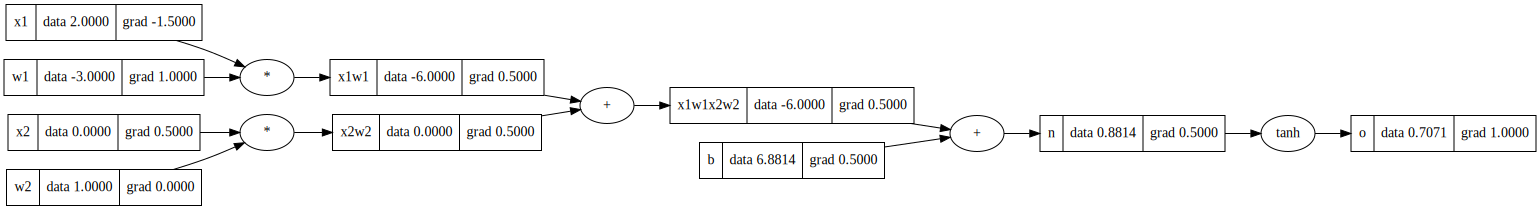

In [13]:
draw_dot(o)

In [14]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b
n.label = 'n'

e = (2*n).exp()
e.label = 'e'
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()

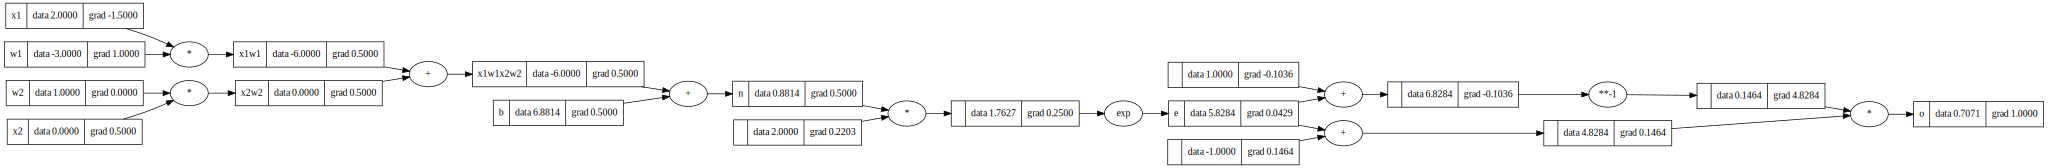

In [15]:
draw_dot(o)

In [24]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())
print(b.grad.item())


0.7071066904050358
-1.5000003851533106
0.5000001283844369
1.0000002567688737
0.0
0.5000001283844369


In [68]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((xi*wi for xi, wi in zip(x, self.w)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

x = [2.0, 3.0, -4.]
n = Neuron(3)
n(x)

Value(data=-0.9970214057235599)

In [69]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

l = Layer(3, 4)
l(x)

[Value(data=0.9994820497886941),
 Value(data=0.8298377051951115),
 Value(data=0.9999053772907689),
 Value(data=0.9931042605851497)]

In [128]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -4.]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.1513400894148993)

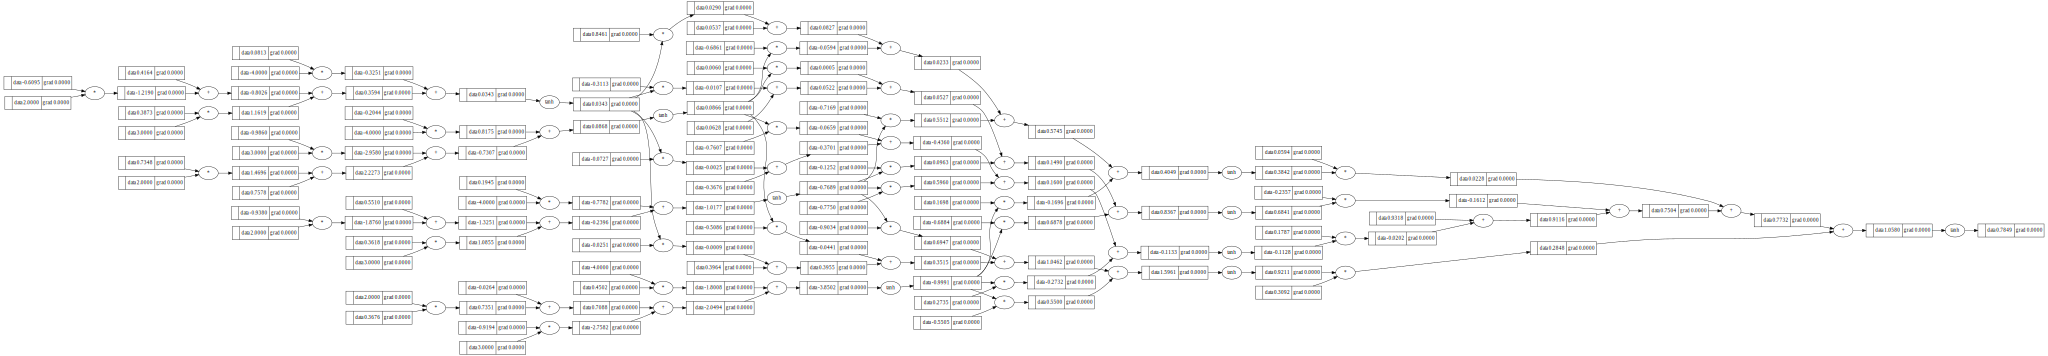

In [48]:
draw_dot(n(x))

In [129]:
xs = [
    [2.0, 3.0, -1.],
    [3., -1., 0.5],
    [0.5, 1., 1.],
    [1., 1., -1.],
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.13508529009035058),
 Value(data=-0.3893638737155219),
 Value(data=0.11946405544933383),
 Value(data=0.05218955654537369)]

In [72]:
loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
loss

Value(data=5.8535868243710265)

In [61]:
loss.backward()

In [62]:
n.layers[0].neurons[0].w[0].grad

-0.00550313712311781

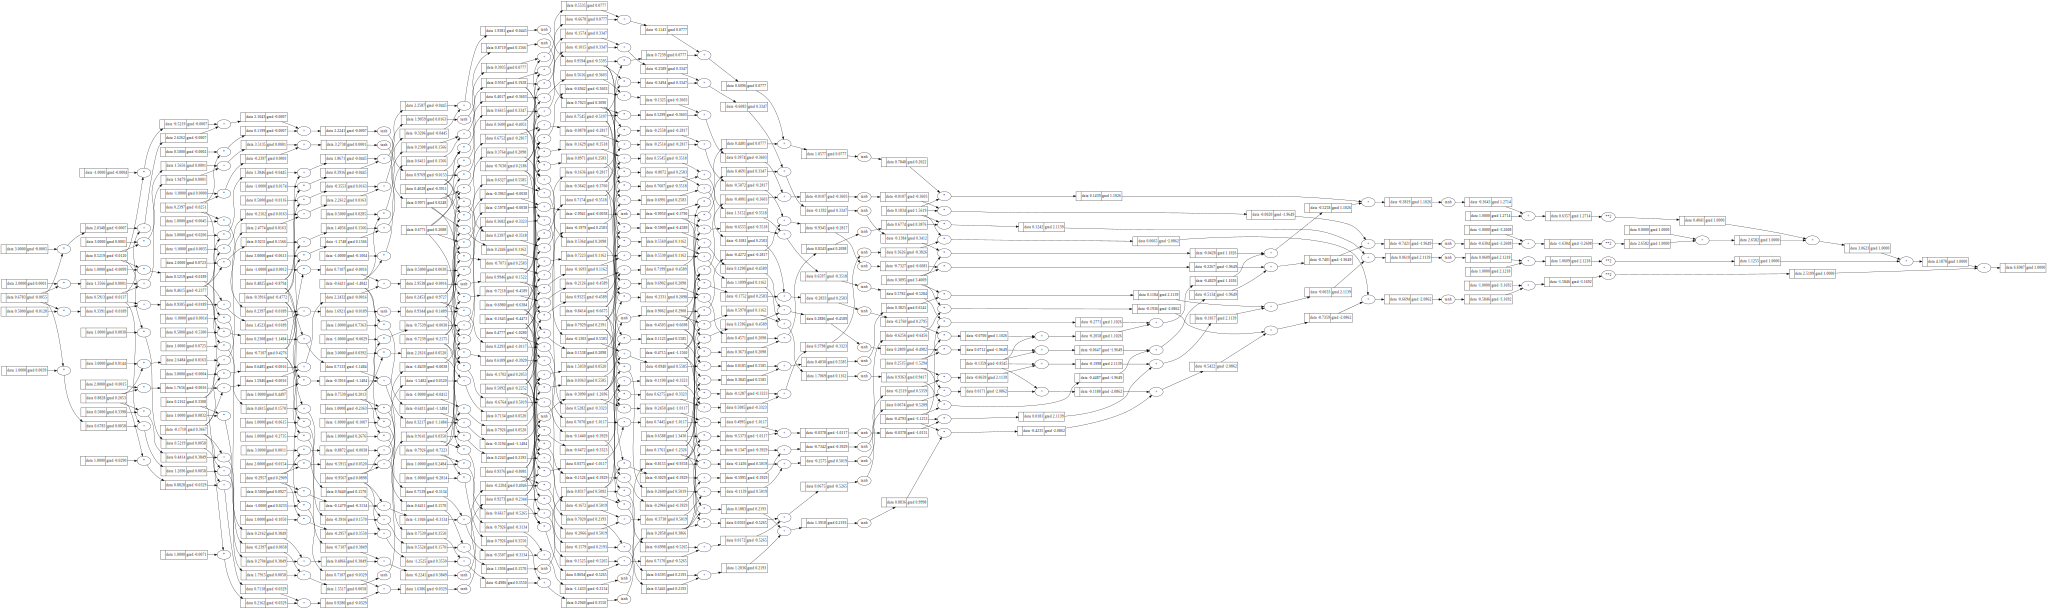

In [63]:
draw_dot(loss)

In [144]:
for k in range(20):
    # foward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))

    # zero grad
    for p in n.parameters():
        p.grad = 0.0

    # backward pass
    loss.backward()

    # update weights
    for p in n.parameters():
        p.data -= 0.1 * p.grad

    # print progress
    print(f'k: {k} loss: {loss.data}')

k: 0 loss: 0.0017264540938554782
k: 1 loss: 0.0017189910153952933
k: 2 loss: 0.0017115894692930956
k: 3 loss: 0.0017042487093430559
k: 4 loss: 0.00169696800126596
k: 5 loss: 0.0016897466224728844
k: 6 loss: 0.0016825838618344166
k: 7 loss: 0.0016754790194554651
k: 8 loss: 0.0016684314064550761
k: 9 loss: 0.0016614403447517022
k: 10 loss: 0.0016545051668532223
k: 11 loss: 0.0016476252156519301
k: 12 loss: 0.0016407998442242548
k: 13 loss: 0.001634028415635092
k: 14 loss: 0.0016273103027465347
k: 15 loss: 0.001620644888031115
k: 16 loss: 0.0016140315633891408
k: 17 loss: 0.0016074697299702915
k: 18 loss: 0.0016009587979991444
k: 19 loss: 0.0015944981866047004


In [145]:
ypred

[Value(data=0.9764246600445227),
 Value(data=-0.9789140706088781),
 Value(data=-0.9828058693052812),
 Value(data=0.9827243818068954)]